# 1. Imports

In [1]:
import pandas as pd
import json
import os
import copy
import time
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 2. Loading data

## 2.1 Identify id:s for Liverpool games

In [2]:
# path = 'C:\\Users\\johnl\\Documents\\GitHub\\opendata\\data\\matches.json'

# with open(path) as f:
#     data = json.load(f)

# # print(json.dumps(data, indent=4, sort_keys=True))

# # Manually found that the Liverpool games has id's 4039 and 2440

path = 'C:\\Users\\jakes\\Desktop\\Data Science\\Mathematical Modelling in Football\\Group Project\\Data\\SkillCorner\\opendata-master\\data\\matches'

id1 = '\\4039'
id2 = '\\2440'

## 2.2 Create player dict

In [3]:
def create_player_dicts(path, match_id):

    with open(path + '\\' + match_id + '\\match_data.json') as f:
        data = json.load(f)

    name_dict = {}
    for player in data['players']:
        obj_id = player['trackable_object']
        first_name = player['first_name']
        last_name = player['last_name']
        name_dict[obj_id] = first_name + ' ' + last_name

    lfc_dict = {}
    lfc_list = []
    if data['id'] == 4039:
        lfc_id = data['away_team']['id']
        for player in data['players']:
            if player['team_id'] == lfc_id:
                obj_id = player['trackable_object']
                first_name = player['first_name']
                last_name = player['last_name']
                lfc_dict[obj_id] = first_name + ' ' + last_name
                lfc_list.append(obj_id)

    return name_dict, lfc_dict, lfc_list

In [4]:
name_dict, lfc_dict, lfc_list = create_player_dicts(path, match_id=id1)

## 2.3 Load and explore tracking data 

In [5]:
def load_tracking_data(path, match_id, name_dict):
    
    with open(path + match_id + '\\structured_data.json') as f:
        data = json.load(f)
    
    df = pd.DataFrame( columns = [i for i in name_dict.keys()] )
    
    new_frame = {}
    for i in df.columns:
        new_frame[i] = None

    li =  []
    for frame in data:
        frame_nr = frame['frame']
        curr_frame = copy.deepcopy(new_frame)
        for obj in frame['data']:
            x = obj['x']
            y = obj['y']
            try:
                obj_id = obj['trackable_object']
                curr_frame[obj_id] = (x, y)
            except:
                None
        row = pd.Series(curr_frame, name = frame_nr)
        li.append(curr_frame)

    df = pd.DataFrame(li)
    
    return df

In [6]:
df = load_tracking_data(path, id1, name_dict)

In [8]:
def create_lfc_dict(df, lfc_list):
    lfc_df = df[lfc_list]

    for col in lfc_df.columns:
        player_df = lfc_df[col]
        p = len([i for i in player_df if i!= None])/len(player_df)
        #if p == 0.0:
        #    lfc_df = lfc_df.drop(columns=col)

    lfc_list = [i for i in lfc_df.columns]
    
    return lfc_df, lfc_list

In [9]:
lfc_df, lfc_list = create_lfc_dict(df, lfc_list)

In [10]:
# col_list = []
# p_list = []
# for col in df.columns:
#     player_df = df[col]
#     p = len([i for i in player_df if i!= None])/len(player_df)
#     # print(col, p)
#     col_list.append(str(col))
#     p_list.append(p)

# plt.bar(x=col_list, height=p_list)

<BarContainer object of 20 artists>

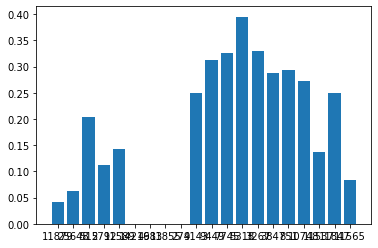

In [11]:
col_list = []
p_list = []
for col in lfc_df.columns:
    player_df = lfc_df[col]
    p = len([i for i in player_df if i!= None])/len(player_df)
    # print(col, p)
    col_list.append(str(col))
    p_list.append(p)

plt.bar(x=col_list, height=p_list)

Obviously, for all players, more than half of the game is not covered by the broadcast data. This is a clear limitation. However, the most important parts of the games (i.e. those when they are close to the ball) is likely to be the ones visible in the broadcast and this may thus not be a huge problem. It is not likely that players far from the ball will run as quick as the ones close to the ball.

**To investigate:**
* Ways to interpolate player positions

# 3. Velocity

## 3.1 Compute velocities 

In [12]:
'''
Manually checked the time intervals. dt = 0.1 seconds
'''


# with open('C:\\Users\\johnl\\Documents\\GitHub\\opendata\\data\\matches\\4039\\structured_data.json') as f:
#         data = json.load(f)

# [frame['time'] for frame in data]

dt = 0.1

In [14]:
# lfc_df_numeric = lfc_df.fillna(value=np.nan)

lfc_cords = pd.DataFrame()

for col in lfc_df.columns:
    x_list = []
    y_list = []
    for i in lfc_df[col]:
        if i == None:
            x_list.append(np.nan)
            y_list.append(np.nan)
        else:
            x_list.append(i[0])
            y_list.append(i[1])
    x_col = str(col)+'_x'
    y_col = str(col)+'_y'
    lfc_cords[x_col] = x_list
    lfc_cords[y_col] = y_list

lfc_cords

,11879_x,11879_y,25648_x,25648_y,515_x,515_y,2792_x,2792_y,11589_x,11589_y,...,851_x,851_y,10748_x,10748_y,11537_x,11537_y,11847_x,11847_y,11565_x,11565_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,-45.892240,-3.379340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.214575,3.732083,-47.965296,-10.154093,NaN,NaN,NaN,NaN,-51.142657,-5.108592
68312,-46.009826,-3.273267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.551537,3.692949,-47.969735,-10.139654,NaN,NaN,NaN,NaN,-51.135727,-5.156821
68313,-46.212437,-3.021497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50.862337,3.676952,-47.977826,-10.132423,NaN,NaN,NaN,NaN,-51.069791,-5.275733
68314,-46.442017,-2.710579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-51.127911,3.638456,-47.986345,-10.127046,NaN,NaN,NaN,NaN,-50.972910,-5.436047


In [16]:
lfc_cords_diff = lfc_cords.diff(periods=1, axis=0)
lfc_cords_diff

,11879_x,11879_y,25648_x,25648_y,515_x,515_y,2792_x,2792_y,11589_x,11589_y,...,851_x,851_y,10748_x,10748_y,11537_x,11537_y,11847_x,11847_y,11565_x,11565_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,-0.182076,0.171674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.426859,0.064200,-0.013296,0.004529,NaN,NaN,NaN,NaN,0.039281,-0.090923
68312,-0.117586,0.106073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.336962,-0.039134,-0.004439,0.014439,NaN,NaN,NaN,NaN,0.006930,-0.048229
68313,-0.202612,0.251771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.310800,-0.015996,-0.008091,0.007231,NaN,NaN,NaN,NaN,0.065936,-0.118912
68314,-0.229579,0.310918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.265574,-0.038497,-0.008519,0.005377,NaN,NaN,NaN,NaN,0.096881,-0.160314


In [30]:
vel_lfc_df = pd.DataFrame()

for i in lfc_list:
    dx_col = str(i)+'_x'
    dy_col = str(i)+'_y'
    dx = lfc_cords_diff[dx_col]
    dy = lfc_cords_diff[dy_col]
    v = np.sqrt(dx**2 + dy**2)/dt
    
    for j in range(len(v)):
        if v[j] > 12.5: # Usain Bolt's top speed
            v[j] = np.nan
    
    vel_lfc_df[i] = v

vel_lfc_df

,11879,25648,515,2792,11589,9143,9449,7745,5318,3267,3847,851,10748,11537,11847,11565
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,2.502471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.039516,1.627968,NaN,4.316603,0.140461,NaN,NaN,0.990457
68312,1.583599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178370,1.182081,NaN,3.392273,0.151057,NaN,NaN,0.487240
68313,3.231716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.763745,1.126262,NaN,3.112110,0.108516,NaN,NaN,1.359694
68314,3.864927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.168877,0.973695,NaN,2.683500,0.100745,NaN,NaN,1.873142


<BarContainer object of 16 artists>

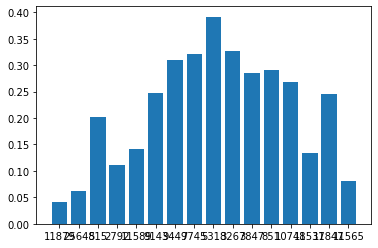

In [34]:
# new check after dropping outlier velocities

p_list2 = [i for i in vel_lfc_df.count()/len(vel_lfc_df)]
col_list2 = [str(i) for i in vel_lfc_df.columns]

plt.bar(x=col_list2, height=p_list2)

In [33]:
# printing how much data (as proportion of total frames in the game) is dropped due to the removing of outliers
assert len(p_list) == len(p_list2)

for i in range(len(p_list)):
    print(p_list[i]-p_list2[i])

NameError: name 'p_list' is not defined

Relatively little data seem to be dropped by removing the outliers which is a sign that we do not lose much valuable information by doing it. It seems reasonable to assume that the benfits of getting rid of obvious outlier speeds outweighs the fact that we get even less data. Hopefully, we can solve some of these gaps by using smoothing later on.

## 3.2 Smoothing of velocities 

In [39]:
smoothed_vel_lfc_df = pd.DataFrame()

n = len(vel_lfc_df)
w = 3

t0 = time.time()
for player in lfc_list:
    v_smoothed = [] 
    for j in range(n):
        try:
            v_smoothed.append( np.mean(vel_lfc_df[player][j-w+1:j+1]) )
        except:
            v_smoothed[j].append( vel_lfc_df[player][j] )
    smoothed_vel_lfc_df[player] = v_smoothed
print(time.time()-t0)

vel_lfc_df

309.65553283691406


,11879,25648,515,2792,11589,9143,9449,7745,5318,3267,3847,851,10748,11537,11847,11565
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,2.502471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.039516,1.627968,NaN,4.316603,0.140461,NaN,NaN,0.990457
68312,1.583599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.178370,1.182081,NaN,3.392273,0.151057,NaN,NaN,0.487240
68313,3.231716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.763745,1.126262,NaN,3.112110,0.108516,NaN,NaN,1.359694
68314,3.864927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.168877,0.973695,NaN,2.683500,0.100745,NaN,NaN,1.873142


In [40]:
smoothed_vel_lfc_df

,11879,25648,515,2792,11589,9143,9449,7745,5318,3267,3847,851,10748,11537,11847,11565
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68311,3.082026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.828777,1.648690,NaN,4.395352,0.198928,NaN,NaN,0.482814
68312,2.383773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.368351,1.538598,NaN,4.318193,0.156803,NaN,NaN,0.577363
68313,2.439262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.327210,1.312104,NaN,3.606995,0.133345,NaN,NaN,0.945797
68314,2.893414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.703664,1.094013,NaN,3.062628,0.120106,NaN,NaN,1.240025


## 3.2.1 Smoothing data

In [21]:
import scipy.signal as signal
calc_df = lfc_cords_diff # new data frame not to intefere with the rest

# Compute distance, raw velocity and velocity with various smoothing filters
for i in lfc_dict:
    calc_df[str(i)+'_dist'] = np.sqrt(calc_df[str(i)+'_x']**2 + calc_df[str(i)+'_y']**2)
    calc_df[str(i)+'_speed'] = calc_df[str(i)+'_dist']/0.1
    calc_df[str(i)+'_speed'] = calc_df[str(i)+'_speed'].apply(lambda x: np.nan if x > 12 else x) # Usain Bolt filter
    calc_df[str(i)+'_acc'] = calc_df[str(i)+'_speed'].diff()/0.1
    calc_df[str(i)+'_SG3_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 3, 1, mode='nearest')    
    calc_df[str(i)+'_SG5_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 5, 1, mode='nearest')
    #calc_df[str(i)+'_SG7_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 7, 1, mode='nearest')
    #calc_df[str(i)+'_SG9_speed'] = signal.savgol_filter(calc_df[str(i)+'_speed'], 9, 1, mode='nearest')
    calc_df[str(i)+'_SG5_acc'] = calc_df[str(i)+'_SG5_speed'].diff()/0.1
    calc_df[str(i)+'_SG3_SG5_acc'] = signal.savgol_filter(calc_df[str(i)+'_SG5_acc'], 3, 1, mode='nearest')

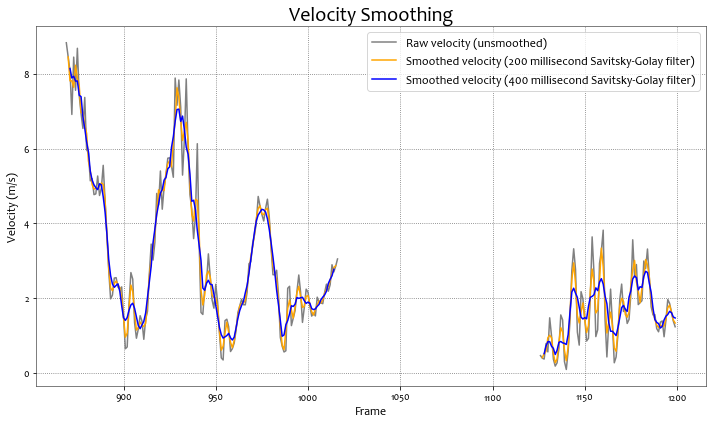

In [22]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.family"] = "Candara"

# Velocity plot
plt.plot(calc_df[800:1200]['5318_speed'], label='Raw velocity (unsmoothed)', color='gray')
plt.plot(calc_df[800:1200]['5318_SG3_speed'], label='Smoothed velocity (200 millisecond Savitsky-Golay filter)', color='orange')
plt.plot(calc_df[800:1200]['5318_SG5_speed'], label='Smoothed velocity (400 millisecond Savitsky-Golay filter)', color='blue')
#plt.plot(calc_df[800:1200]['5318_SG7_speed'], label='Smoothed velocity (600 millisecond Savitsky-Golay filter)', color='blue')
#plt.plot(calc_df[800:1200]['5318_SG9_speed'], label='Smoothed velocity (800 millisecond Savitsky-Golay filter)', color='blue')
plt.legend(fontsize=12)
plt.grid(True, color = 'dimgray', linestyle='dotted')
plt.title("Velocity Smoothing", fontsize=20)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)
plt.tight_layout()

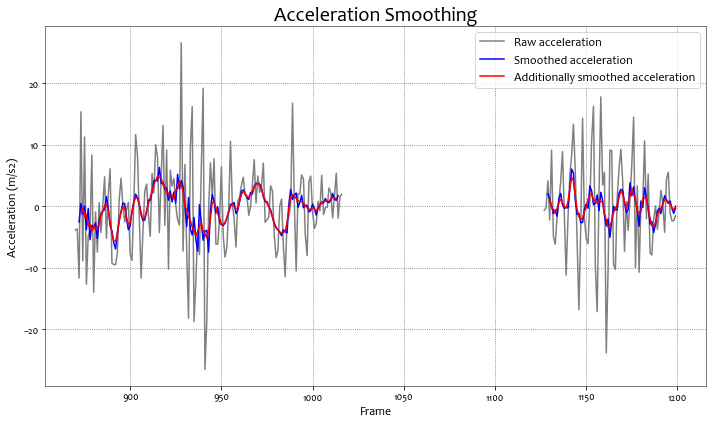

In [23]:
# Acceleration plot
plt.plot(calc_df[800:1200]['5318_acc'], label='Raw acceleration', color='gray')
plt.plot(calc_df[800:1200]['5318_SG5_acc'], label='Smoothed acceleration', color='blue')
plt.plot(calc_df[800:1200]['5318_SG3_SG5_acc'], label='Additionally smoothed acceleration', color='red')
plt.legend(fontsize=12)
plt.grid(True, color = 'dimgray', linestyle='dotted')
plt.title("Acceleration Smoothing", fontsize=20)
plt.xlabel('Frame', fontsize=12)
plt.ylabel('Acceleration (m/s2)', fontsize=12)
plt.tight_layout()

In [ ]:
# Savitsky-Golay 5 window filter for velocity 
# Additional filter improvement but not strictly necessary

## 3.3 Decompose into speed zones

In [49]:
def dist_per_speed_zone(vel_df, player_id, bins):
    x = vel_df[player_id]
    w = len(x)*[0.1]
    
    n = plt.hist(x, bins = bins, weights = w)
    
    return n

(array([1444.7, 1045.7,  209.4,   21.1,    1.7]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5]),
 <a list of 5 Patch objects>)

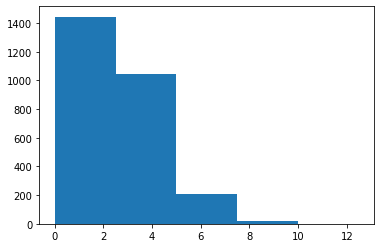

In [58]:
player_id = 5318
bins = [0,2.5,5,7.5,10,12.5]

dist_per_speed_zone(smoothed_vel_lfc_df, player_id, bins)

In [62]:
def distance_in_speed_zone(vel_df, player_id, min_speed, max_speed):
    return sum( vel_df[player_id].between(min_speed, max_speed) ) /10

In [65]:
player_id = 5318
min_speed = 2
max_speed = 8

distance_in_speed_zone(smoothed_vel_lfc_df, player_id, min_speed, max_speed)

1534.3

## 3.4 Identify sprints 

In [54]:
# TBD

# 4. Acceleration

## 4.1 Compute acceleration

In [ ]:
#TBD

Smooothing of acceleration values shall not be needed since we smoothed the velocities and computed acceleration from this. This means that we should have removed most of the noise in the data already.

## 4.2 Decompose into acceleration/deceleration zones 

In [ ]:
#TBD

# 5. Acceleration/Deceleration profiles

In [ ]:
# TBD

# 6. Sequences of peak intensity

In [ ]:
# TBD

# 7. Metabolic power

In [ ]:
# TBD